# SSVEP-EEG Signal Classification based on Emotiv EPOC BCI and Raspberry Pi

Dataset: https://ieee-dataport.org/documents/ssvep-eeg-data-collection-using-emotiv-epoc#files


- 10 visual stimuli frequencies (7, 9, 11 and 13)
- 2 electrodes (LO, RO) 
- 128 samples per second, Stimuli was provided for 3.5s

Asanza, V., Avilés-Mendoza, K., Trivino-Gonzalez, H., Rosales-Uribe, F., Torres-Brunes, J., Loayza, F. R., ... & Tinoco-Egas, R. (2021). SSVEP-EEG signal classification based on emotiv EPOC BCI and raspberry Pi. IFAC-PapersOnLine, 54(15), 388-393.
https://www.sciencedirect.com/science/article/pii/S240589632101692X

### 1. Data Visualization

In [2]:
import pandas as pd

DATASET = '../Dataset/3_Filtered_Data/'
stimuli = ['7Hz', '9Hz', '11Hz', '13Hz', 'Baseline']

for s in stimuli:
    stim = pd.read_csv(DATASET + s + '/muestra4.csv')
    #stim[['EEG.O1', 'EEG.O2']].plot(subplots=True)

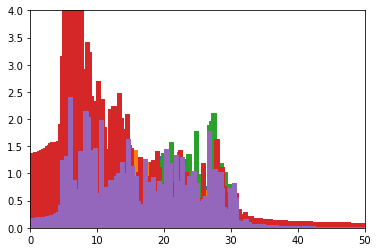

In [3]:
# FFT
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

Fs = 128
T = 1/Fs

for s in stimuli:
    stim = pd.read_csv(DATASET + s + '/muestra11.csv')
    #stim[['EEG.O1', 'EEG.O2']].plot(subplots=True)

    signal = stim['EEG.O1'].to_numpy()

    s_fft = np.fft.fft(signal)
    amplitude = abs(s_fft)*(2/len(s_fft))
    frequency = np.fft.fftfreq(len(s_fft), T)

    plt.xlim(0, 50)
    plt.ylim(0, 4)
    plt.bar(frequency, amplitude)
    #plt.show()

### 2. Classification Preprocessing

#### 1) Feature Extraction

Mean, Mean - weight I, Mean - weight II, Log Detector, Median, Variance, Mean absolute difference, Mean frecuency, Peak frecuency, Variance central frecuency, Maximum PSD, Amplitude Histogram (10 ranges)

Git repo (equation, refernce): https://github.com/kaviles22/EEG_SignalsClassification

In [28]:
# Feature Extraction
import csv, os, math
import pandas as pd
import numpy as np
import scipy.signal

DATASET = '../Dataset/3_Filtered_Data/'
stimuli = ['7Hz', '9Hz', '11Hz', '13Hz', 'Baseline']
channel = ['EEG.O1', 'EEG.O2']


# Read All File Lists
def getFileName(path_dir):
    file_list = os.listdir(path_dir)
    file_list.sort()
    dataList = []

    for f in file_list:
        if f.find('.csv') != -1:
            dataList.append(f)

    return dataList


def HistogramaAmplitud(frequency, spectrum):
    intervals = [[x * 6.5, x * 6.5 + 6.5] for x in range(0, 10)]
    intervalVals = [[],[],[],[],[],[],[],[],[],[]]

    sp = spectrum.tolist()
    total = sum(sp)

    for freq in frequency:
        idx = 0
        for inter in intervals:
            if inter[0] <= freq < inter[1]:
                intervalVals[idx].append(sp[int(np.where(frequency == freq)[0])])
                break
            idx += 1

    histAmp = [sum(x)/total for x in intervalVals]
    
    return histAmp


# FFT (5~35 Hz)
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
        nyq = 0.5 * fs  # sampling rate (fs)
        low = lowcut / nyq
        high = highcut / nyq
        sos = scipy.signal.butter(order, [low, high], analog=False, btype='band', output='sos')
        y = scipy.signal.sosfilt(sos, data)
        return y


# Extract Features
for s in stimuli:
    fList = getFileName(DATASET + s)

    for f in fList:
        trial = pd.read_csv(DATASET + s + '/' + f)
        trialFeature = []

        for c in channel:
            filtered = butter_bandpass_filter(trial[c] - np.mean(trial[c]), lowcut=5, highcut=35, fs=448, order=3)
            filtered = pd.Series(filtered)

            # Mean
            mean = filtered.mean()

            # Mean - weight I
            res = []
            for i in range(len(filtered)):
                i += 1
                if i <= 0.75*len(filtered) and i >= 0.25*len(filtered):
                    w = 1
                else:
                    w = 0.5
                res.append(abs(trial.iloc[i-1][c])*w)
            mean1 = np.array(res).mean()

            # Mean - weight II
            res = []
            for i in range(len(filtered)):
                i += 1
                if i <= 0.75*len(filtered) and i >= 0.25*len(filtered):
                    w = 1
                elif i < 0.25*len(filtered) :
                    w = 4*i/len(filtered)
                else:
                    w = 4*(len(filtered)-i)/len(filtered)
                res.append(abs(trial.iloc[i-1][c])*w)
            mean2 = np.array(res).mean()

            # Log Detector
            #logDetector = math.exp(np.log(abs(filtered).to_frame()).mean()[c])

            # Median
            median = filtered.median()

            # Variance
            variance = filtered.var()

            # Mean absolute difference
            mad = np.median(np.absolute(filtered - np.median(filtered, axis=0)), axis=0)

            # FFT
            freq, sp = scipy.signal.periodogram(filtered, 128)
            frequency = freq[30:60]
            spectrum = sp[30:60]

            # Mean frecuency
            meanFreq = ((freq * sp).sum())/(sp.sum())

            # Peak frecuency
            frequency_peak_indice = np.argmax(spectrum)
            peakFreq = frequency[frequency_peak_indice]
            
            # Variance central frecuency
            frequency_avg = np.mean(freq)
            vcf = np.sum(sp * pow(freq - frequency_avg,2))/frequency_avg
            
            # Maximum PSD
            maxPSD = np.max(spectrum)
            
            # Amplitude Histogram (10 ranges)
            ampHist = HistogramaAmplitud(freq, sp)

            #channelFeature = [mean, mean1, mean2, logDetector, median, variance, mad, meanFreq, peakFreq, vcf, maxPSD]
            channelFeature = [mean, mean1, mean2, median, variance, mad, meanFreq, peakFreq, vcf, maxPSD]
            channelFeature.extend(ampHist)

            trialFeature.append(channelFeature)


        trialFeature = np.array(trialFeature)
        np.save('../Dataset/4_Feature Extracted Data/' + s + '_' + f, trialFeature)


### 3. Classification

#### 1) Divide into Training, Valid, Test set

Divide the data to Training (70%), Validation (15%) and Test (15%) set.

In [29]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

DATASET = '../Dataset/4_Feature Extracted Data/'
stimuli = ['7Hz', '9Hz', '11Hz', '13Hz', 'Baseline']


# Read All File Lists
def getFileName(path_dir):
    file_list = os.listdir(path_dir)
    file_list.sort()
    dataList = []

    for f in file_list:
        if f.find('.npy') != -1:
            dataList.append(f)

    return dataList


# Make X, y Format
npyList = getFileName(DATASET)
X1 = []  # O1
X2 = []  # O2
y = []

for n in npyList:
    data = np.load(DATASET + n)
    X1.append(data[0])
    X2.append(data[1])
    for s in stimuli:
        if s in n:
            y.append(s)



# Data Normalization
from sklearn.preprocessing import MinMaxScaler

X1 = MinMaxScaler().fit_transform(X1)
X2 = MinMaxScaler().fit_transform(X2)

X = []
for i in range(len(X1)):
    X.append(np.concatenate((X1[i], X2[i]), axis=0))


import csv
with open('features.csv', 'w', newline='') as file :
    write = csv.writer(file)
    write.writerows(X)



# Divide dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

3024
757


#### 3) Learning & Classificaiton

Classification with SVM, MLP, RF, KNN, XGBoost methods.

In [30]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

0.19947159841479525


In [37]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(X_train, y_train)

print(classifier.score(X_test, y_test))

0.21268163804491413
